<a href="https://colab.research.google.com/github/otitamario/sp-pa-gep/blob/main/notebooks/Experiment_5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the repository into Colab runtime
!git clone https://github.com/otitamario/sp-pa-gep.git

# Move into repo root
%cd sp-pa-gep

# Make sure Python sees the project root
import sys
import os

# Move to repo root if needed
if not os.path.exists("src"):
    %cd sp-pa-gep

sys.path.append(".")

Cloning into 'sp-pa-gep'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 94 (delta 34), reused 38 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 897.18 KiB | 8.71 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/sp-pa-gep


In [2]:
import sys
sys.path.append("..")

In [3]:
#Projection onto box C
import numpy as np
import matplotlib.pyplot as plt
import os


def proj_box(x, low=-2.0, high=5.0):
    return np.clip(x, low, high)


In [4]:
#Proximal mapping P(x)
def prox_quartic(x, maxit=50, tol=1e-12):
    nx = np.linalg.norm(x)
    if nx == 0.0:
        return x.copy()
    a = nx**2  # ||x||^2

    # Solve t + a t^3 = 1 for t in (0,1]
    # good initial guess
    t = 1.0 / (1.0 + a)

    for _ in range(maxit):
        f = t + a * t**3 - 1.0
        df = 1.0 + 3.0 * a * t**2
        t_new = t - f / df
        # keep positive
        if t_new <= 0:
            t_new = 0.5 * t
        if abs(t_new - t) < tol:
            t = t_new
            break
        t = t_new

    return t * x


In [6]:
#Build a PSD matrix A>=0
def make_psd_matrix(m=5, seed=0):
    rng = np.random.default_rng(seed)
    B = rng.uniform(-2, 2, size=(m, m))
    A = B.T @ B  # PSD
    # normalize to keep scale moderate
    A = A / np.linalg.norm(A, ord=2)
    return A


In [7]:
#Define F(x)=Ax + P(x)
def make_F(A):
    def F(x):
        return A @ x + prox_quartic(x)
    return F


In [8]:
#Inner fixed-point solver for the resolvent
#u=PC(x−rF(u))

def resolvent_inner_fixed_point(x, r, F, inner_tol=1e-10, inner_maxit=200):
    z = proj_box(x)  # initial guess inside C
    for _ in range(inner_maxit):
        z_new = proj_box(x - r * F(z))
        if np.linalg.norm(z_new - z) <= inner_tol:
            return z_new
        z = z_new
    return z  # return last iterate if not fully converged


In [9]:
#SPPA and WPPA outer loops
def residual_R(x, r, F):
    return np.linalg.norm(x - proj_box(x - r * F(x)))

def run_SPPA(x0, u_anchor, r, F, N=200, inner_tol=1e-10):
    x = x0.copy()
    xs = [x.copy()]
    Rvals = [residual_R(x, r, F)]
    steps = []

    for n in range(N):
        alpha = 1.0 / (n + 2.0)
        u_n = resolvent_inner_fixed_point(x, r, F, inner_tol=inner_tol)

        x_new = alpha * u_anchor + (1.0 - alpha) * u_n
        steps.append(np.linalg.norm(x_new - x))
        x = x_new

        xs.append(x.copy())
        Rvals.append(residual_R(x, r, F))

    return np.array(xs), np.array(Rvals), np.array(steps)

def run_WPPA(x0, r, F, N=200, inner_tol=1e-10):
    x = x0.copy()
    xs = [x.copy()]
    Rvals = [residual_R(x, r, F)]
    steps = []

    for n in range(N):
        alpha = 1.0 / (n + 2.0)
        u_n = resolvent_inner_fixed_point(x, r, F, inner_tol=inner_tol)

        x_new = alpha * x + (1.0 - alpha) * u_n
        steps.append(np.linalg.norm(x_new - x))
        x = x_new

        xs.append(x.copy())
        Rvals.append(residual_R(x, r, F))

    return np.array(xs), np.array(Rvals), np.array(steps)


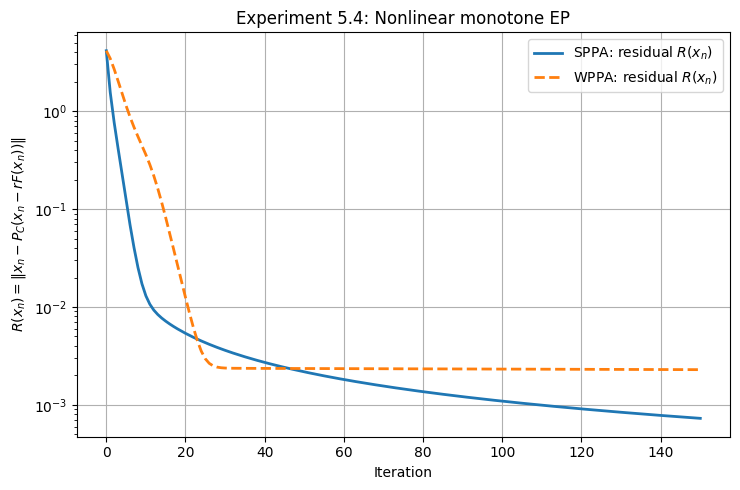

In [11]:
#Run Experiment and plot
m = 5
A = make_psd_matrix(m=m, seed=123)
F = make_F(A)

# parameters
r = 0.5          # keep moderate for inner fixed-point stability
N = 150
inner_tol = 1e-10

# initial point (outside box to test projection)
x0 = np.ones(m) * 4.0
u_anchor = np.zeros(m)  # in C

xs_sppa, R_sppa, step_sppa = run_SPPA(x0, u_anchor, r, F, N=N, inner_tol=inner_tol)
xs_wppa, R_wppa, step_wppa = run_WPPA(x0, r, F, N=N, inner_tol=inner_tol)

plt.figure(figsize=(7.5,5))
plt.semilogy(R_sppa, label="SPPA: residual $R(x_n)$", linewidth=2)
plt.semilogy(R_wppa, label="WPPA: residual $R(x_n)$", linestyle="--", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel(r"$R(x_n)=\|x_n - P_C(x_n-rF(x_n))\|$")
plt.title("Experiment 5.4: Nonlinear monotone EP")
plt.grid(True)
plt.legend()
plt.tight_layout()

os.makedirs("figures", exist_ok=True)
plt.savefig("figures/exp5_4_nonlinear_residual.png", dpi=300, bbox_inches="tight")
plt.show()


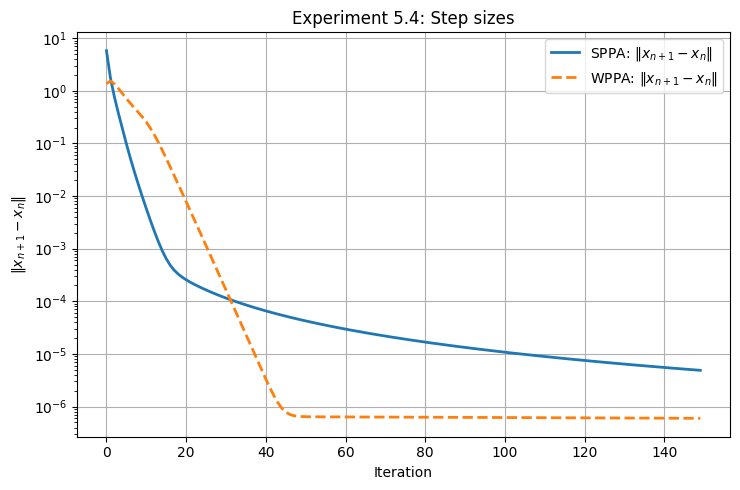

In [12]:
# Plot norms ||x_{n+1}-x_n||
plt.figure(figsize=(7.5,5))
plt.semilogy(step_sppa, label=r"SPPA: $\|x_{n+1}-x_n\|$", linewidth=2)
plt.semilogy(step_wppa, label=r"WPPA: $\|x_{n+1}-x_n\|$", linestyle="--", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel(r"$\|x_{n+1}-x_n\|$")
plt.title("Experiment 5.4: Step sizes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/exp5_4_nonlinear_steps.png", dpi=300, bbox_inches="tight")
plt.show()
